
**Part 1**

Import and cleaned data based on relavant data columns and dropping NAN values

README: Change filepath to local/drive location for Accepted CSV. Please add the original dataset into this folder

In [ ]:

##Change this to the accepted reduced
file_path = '../data/accepted_reduced'
import pandas as pd

# Define the value of n (how many rows you want to skip)
n = 4  # Change this to the desired value

# Read the CSV file skipping rows except every nth row
# You can specify other parameters such as dtype, header, etc., based on your CSV file structure
# Adjust chunksize to control the number of rows read at once if memory is still an issue
chunksize = 100  # You can adjust this based on your system's memory capacity
rows = []

for chunk in pd.read_csv(file_path, chunksize=chunksize, skiprows=lambda x: x % n != 0):
    rows.append(chunk)

# Concatenate all chunks into a single DataFrame
accepted_dat = pd.concat(rows, ignore_index=True)


Mounted at /content/drive


In [ ]:

# drop columns that have no correlation with loan default / nondefault / expected return
# also drop columns that we will not know the value of at the time of loan application since we will not be able to predict based on these in the future
irrelevant_columns = ['all_util', 'bc_open_to_buy', 'bc_util', 'desc', 'earliest_cr_line', 'emp_title',
                       'funded_amnt', 'funded_amnt_inv', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m',
                       'inq_last_6mths', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
                       'last_pymnt_amnt', 'last_pymnt_d', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
                       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_last_record', 'mths_since_recent_inq',
                       'next_pymnt_d', 'percent_bc_gt_75', 'policy_code', 'purpose', 'pymnt_plan', 'revol_util',
                       'title', 'tot_hi_cred_lim', 'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit',
                       'total_pymnt', 'total_pymnt_inv', 'total_rev_hi_lim', 'url', 'zip_code', 'sec_app_inq_last_6mths',
                       'sec_app_revol_util', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
                       'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                       'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
                       'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag',
                       'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage',
                       'settlement_term']

# keep these columns for indexing
index_cols = ['id', 'member_id']


# could predict these columns
response_cols = ['loan_status', 'recoveries', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp']


In [ ]:

# creates new df without irrelevant columns
for col in irrelevant_columns:
    try:
        accepted_dat.drop(columns=[col], inplace=True)
    except KeyError as e:
        print(f"Could not drop column '{col}': {e}")

# creates copy of df
accepted_copy = accepted_dat.copy()


In [ ]:

# calculates percentage of null values in each column
nan_percentage = accepted_dat.isnull().mean() * 100

# indexes the columns with greater than 75% null
columns_to_drop = nan_percentage[nan_percentage > 75].index.tolist()

# drops the columns with greater than 75% null
accepted_reduced = accepted_copy.drop(columns = columns_to_drop)



In [ ]:
# drops the na values for the reduced df
accepted_reduced = accepted_reduced.dropna()
print(len(accepted_reduced))

51035


In [ ]:
import numpy as np #Error debugging with Colab

# Assuming 'accepted_reduced' is your DataFrame
print(accepted_reduced['loan_status'].unique())

# Use .loc to create the new column and avoid 'SettingWithCopyWarning'
accepted_reduced.loc[:, 'loan_status_bin'] = np.where(accepted_reduced['loan_status'].isin(['Fully Paid', 'Current', 'In Grace Period']), 1, 0)

print(accepted_reduced.iloc[0])

counts = accepted_reduced['loan_status_bin'].value_counts()
print(counts)


['Current' 'Charged Off' 'Fully Paid' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default']
id                        68516838
loan_amnt                  23850.0
term                     60 months
int_rate                     17.27
installment                 596.21
                           ...    
pct_tl_nvr_dlq                90.9
pub_rec_bankruptcies           0.0
tax_liens                      0.0
total_bal_ex_mort          32673.0
loan_status_bin                  1
Name: 12, Length: 69, dtype: object
1    45058
0     5977
Name: loan_status_bin, dtype: int64


<ipython-input-6-775b487ad106>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_reduced.loc[:, 'loan_status_bin'] = np.where(accepted_reduced['loan_status'].isin(['Fully Paid', 'Current', 'In Grace Period']), 1, 0)


In [ ]:
# examine the column with dtype object since we will need to encode these
object_columns = accepted_reduced.select_dtypes(include=['object']).columns

# loop through each column listed and print a unique or sample value
for col in object_columns:
    # attempt to print a unique value if it exists; otherwise, print any sample value
    unique_values = accepted_reduced[col].unique()
    sample_value = unique_values[0] if len(unique_values) > 0 else df[col].iloc[0]
    print(f"Column: {col}, Sample Value: {sample_value}")

Column: id, Sample Value: 68516838
Column: term, Sample Value:  60 months
Column: grade, Sample Value: D
Column: sub_grade, Sample Value: D3
Column: emp_length, Sample Value: 10+ years
Column: home_ownership, Sample Value: OWN
Column: verification_status, Sample Value: Not Verified
Column: loan_status, Sample Value: Current
Column: addr_state, Sample Value: VA
Column: application_type, Sample Value: Individual


In [ ]:
from sklearn.preprocessing import LabelEncoder
#Source ChatGPT
# Columns to be label encoded
columns_to_encode = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'addr_state']

# Apply label encoding to each column
for col in columns_to_encode:
    # Initialize the LabelEncoder
    le = LabelEncoder()
    # Fit and transform the data and replace the column in the df
    accepted_reduced[col + '_encoded'] = le.fit_transform(accepted_reduced[col].astype(str))


In [ ]:
# Columns to be one-hot encoded
columns_to_onehot = ['verification_status', 'application_type']

# Apply one-hot encoding to the specified columns
df = pd.get_dummies(accepted_reduced, columns=columns_to_onehot)

In [ ]:
# getting rid of the "months" at the end of "term" and keeping just the integer value
print(accepted_reduced['term'].unique())
accepted_reduced["term"] = (accepted_reduced["term"].str[1:3]).astype(int)
print(accepted_reduced["term"].unique())

[' 60 months' ' 36 months']
[60 36]


**Part 2: Logistic regression model to predict probability of default:** --
We will use this probability of default to calculate expected return in part 3

In [ ]:
# prompt: print the unique combinations of sub_grade and sub_grade_encoded in the accepted_reduced dataframe and sort by sub_grade_encoded

# Print unique combinations of 'sub_grade' and 'sub_grade_encoded' columns
unique_combinations = accepted_reduced[['sub_grade', 'sub_grade_encoded']].drop_duplicates()

# Sort the combinations by 'sub_grade_encoded' in ascending order
sorted_combinations = unique_combinations.sort_values('sub_grade_encoded')

# Print the sorted combinations
print(sorted_combinations)


       sub_grade  sub_grade_encoded
277           A1                  0
468           A2                  1
161           A3                  2
627           A4                  3
121           A5                  4
73            B1                  5
114           B2                  6
57            B3                  7
23            B4                  8
248           B5                  9
190           C1                 10
180           C2                 11
74            C3                 12
84            C4                 13
68            C5                 14
97            D1                 15
81            D2                 16
12            D3                 17
52            D4                 18
269           D5                 19
1342          E1                 20
776           E2                 21
140           E3                 22
20            E4                 23
1405          E5                 24
1175          F1                 25
364           F2            

In [ ]:
# prompt: calculate the percentage of loan default by subgrade in the accepted_reduced dataframe by dividing the number of 0's in the loan_status_bin column by the total number of entries in the subgrade

# Calculate the percentage of loan default by subgrade
grade_default_rates = 1 - accepted_reduced.groupby('grade')['loan_status_bin'].mean()
print(grade_default_rates)


grade
A    0.032657
B    0.076104
C    0.126377
D    0.166750
E    0.253280
F    0.344956
G    0.379661
Name: loan_status_bin, dtype: float64


In [ ]:
# prompt: now use the subgrade_default_rates to make a column called 'prob_default' in the accepted_reduced dataframe that puts the default rate with the corresponding subgrade

accepted_reduced['prob_default'] = accepted_reduced['grade'].map(grade_default_rates)
accepted_reduced['prob_nondefault'] = 1 - accepted_reduced['prob_default']
print(accepted_reduced[['prob_default','prob_nondefault', 'grade']])


        prob_default  prob_nondefault grade
12          0.166750         0.833250     D
20          0.253280         0.746720     E
23          0.076104         0.923896     B
52          0.166750         0.833250     D
57          0.076104         0.923896     B
...              ...              ...   ...
565141      0.126377         0.873623     C
565150      0.126377         0.873623     C
565164      0.126377         0.873623     C
565166      0.126377         0.873623     C
565173      0.076104         0.923896     B

[51035 rows x 3 columns]


**Part 3: Random forest model to predict expected return** -- using probability of default from previous model

In [ ]:
print(accepted_reduced['term'])

# calculations for the total return on a completed loan

# monthly interest rate
monthly_interest_rate = accepted_reduced['int_rate'] / 12 /100

# calculate monthly payment
accepted_reduced['monthly_payment'] = accepted_reduced['loan_amnt'] * monthly_interest_rate

# calculates total interest
# test_data['total_interest'] = (monthly_payment * test_data['term']) - test_data['loan_amnt']

accepted_reduced['total_payment'] = accepted_reduced['monthly_payment'] * accepted_reduced['term']

# total payout
# test_data['total_payment'] = monthly_payment * test_data['term']

print(accepted_reduced['total_payment'])

12        60
20        60
23        36
52        60
57        36
          ..
565141    60
565150    60
565164    60
565166    60
565173    60
Name: term, Length: 51035, dtype: int64
12        20594.4750
20        23677.5000
23         2587.2000
52        21137.2125
57         2940.0000
             ...    
565141    11192.0000
565150    11592.0000
565164    13490.0000
565166    14055.3000
565173    12588.0000
Name: total_payment, Length: 51035, dtype: float64


In [ ]:
# calculating expected return and expected percent return
accepted_reduced["expected_return"] = round(accepted_reduced["prob_nondefault"] * accepted_reduced["total_payment"] - accepted_reduced["prob_default"] * accepted_reduced["loan_amnt"])
accepted_reduced["expected_percent_return"] = accepted_reduced["expected_return"]/ accepted_reduced["loan_amnt"]

accepted_reduced['ann_exp_pct_ret'] = (accepted_reduced['expected_percent_return'] / accepted_reduced['term']) * 12 *100

# create threshold for % expected returns on loans with return in top 10%
high_return_thresh = accepted_reduced['ann_exp_pct_ret'].quantile(.9)
accepted_reduced["high_return_bin"] = (accepted_reduced["ann_exp_pct_ret"] > high_return_thresh).astype(int)

# seeing how many high expected return loans there are
high_return_df = accepted_reduced[accepted_reduced["expected_percent_return"] >= high_return_thresh]
high_return_df.sort_values(by="expected_percent_return", ascending=False)
high_return_df.head()
print("Number of high expected return loans: ", len(high_return_df))

print(accepted_reduced['expected_percent_return'])
print(accepted_reduced['ann_exp_pct_ret'])

Number of high expected return loans:  0
12        0.552746
20        0.512121
23        0.222625
52        0.581934
57        0.195500
            ...   
565141    0.484750
565150    0.506563
565164    0.462900
565166    0.506546
565173    0.408500
Name: expected_percent_return, Length: 51035, dtype: float64
12        11.054927
20        10.242424
23         7.420833
52        11.638682
57         6.516667
            ...    
565141     9.695000
565150    10.131250
565164     9.258000
565166    10.130928
565173     8.170000
Name: ann_exp_pct_ret, Length: 51035, dtype: float64


In [ ]:
columns_to_exclude = ['id', 'loan_status', 'recoveries', 'total_rec_int',
                   'total_rec_late_fee', 'total_rec_prncp', 'addr_state',
                   'home_ownership', 'grade', 'sub_grade', 'emp_length', 'verification_status',
                   'application_type', 'loan_status_bin', 'out_prncp',
                  'out_prncp_inv', 'collection_recovery_fee', 'grade', 'sub_grade', 'emp_length',
                   'home_ownership', 'addr_state', 'verification_status', 'application_type',
                   'grade', 'sub_grade', 'emp_length', 'home_ownership', 'addr_state',
                   'verification_status', 'application_type', "total_payment", "expected_return", "prob_default",
                    "prob_nondefault", "expected_percent_return", "high_return_bin", 'total_payment', 'monthly_payment', 'installment',
                      'ann_exp_pct_ret']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Source: ChatGPT
# Initialize predictors and response
# get rid of all new variables since we won't know those at time of future prediction
X2 = accepted_reduced.drop(columns = columns_to_exclude)
y2 = accepted_reduced['high_return_bin']

# train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.4, random_state = 23)

# initialize the model
mod1 = RandomForestClassifier(n_estimators = 100, random_state = 23)

# train model
mod1.fit(X_train2, y_train2)

# predict the test set
y_pred2 = mod1.predict(X_test2)

# evaluate accuracy in predicting high expected return loans
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.9939


**Part 4: Examining most significant variables in determining high expected return loans**

In [ ]:
# Assuming your Random Forest model is named clf
importances = mod1.feature_importances_

# Get the feature names after preprocessing (one-hot encoding might change the number of features)
feature_names = X_train2.columns

# Create a DataFrame to hold feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the ranked feature importances
print(importances_df)

                           Feature  Importance
2                         int_rate    0.227601
52               sub_grade_encoded    0.192732
1                             term    0.174179
51                   grade_encoded    0.119687
0                        loan_amnt    0.041248
4                              dti    0.010925
11                       revol_bal    0.009979
3                       annual_inc    0.009543
17                     tot_cur_bal    0.009350
27                     avg_cur_bal    0.008895
50               total_bal_ex_mort    0.008105
32  mths_since_recent_revol_delinq    0.008079
8           mths_since_last_delinq    0.007888
23                    total_bal_il    0.007775
47                  pct_tl_nvr_dlq    0.007663
22              mths_since_rcnt_il    0.007573
14     mths_since_last_major_derog    0.007397
31            mths_since_recent_bc    0.007183
12                       total_acc    0.006786
55              addr_state_encoded    0.006726
40           

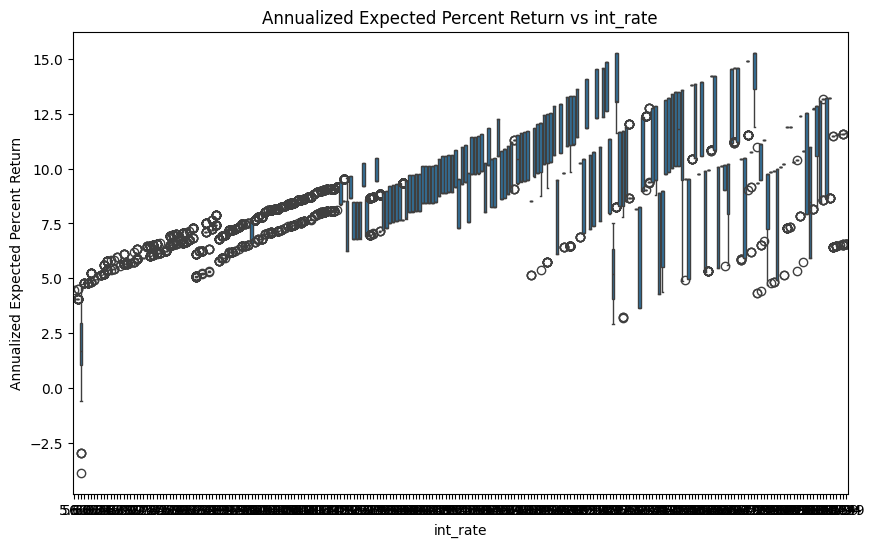

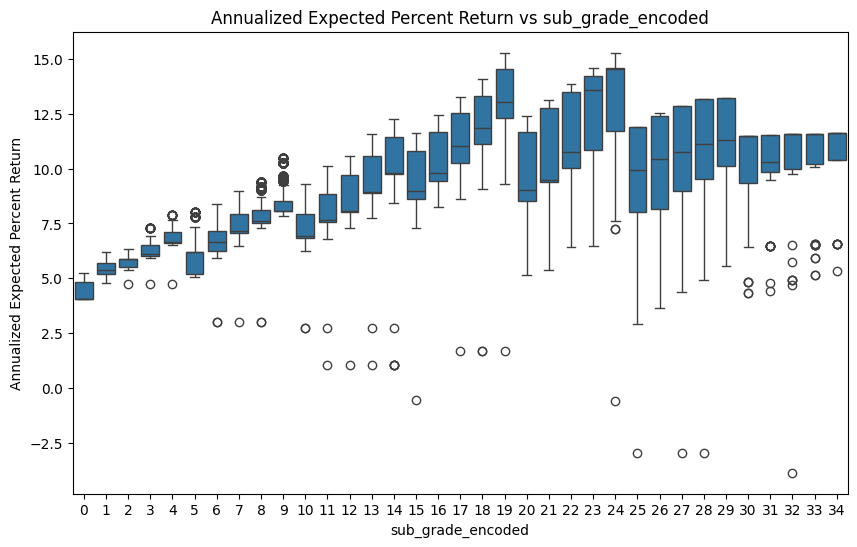

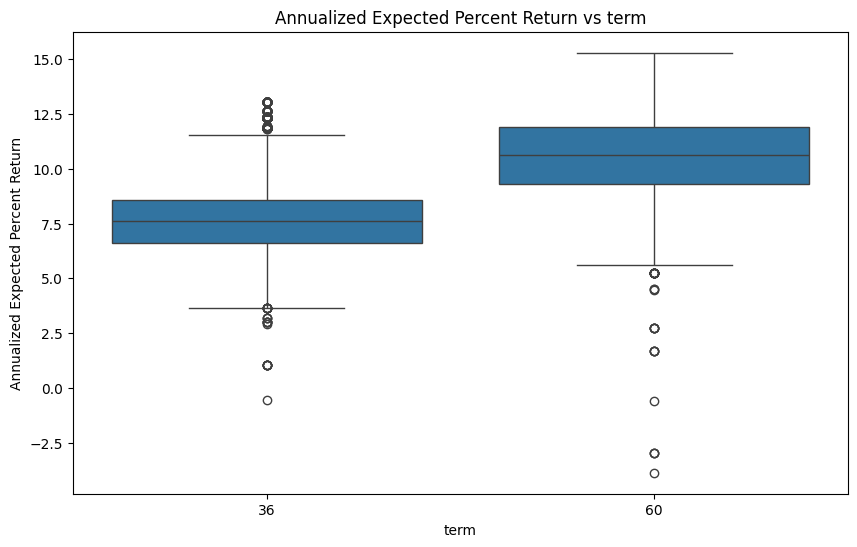

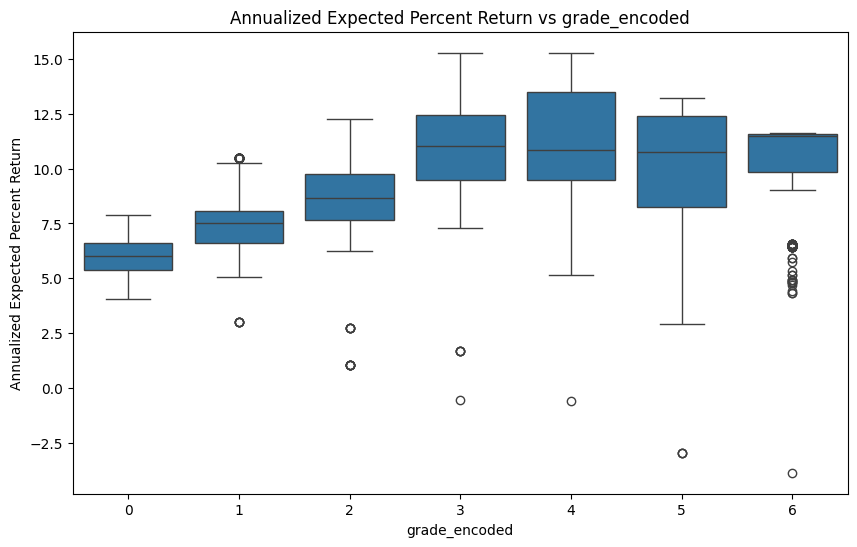

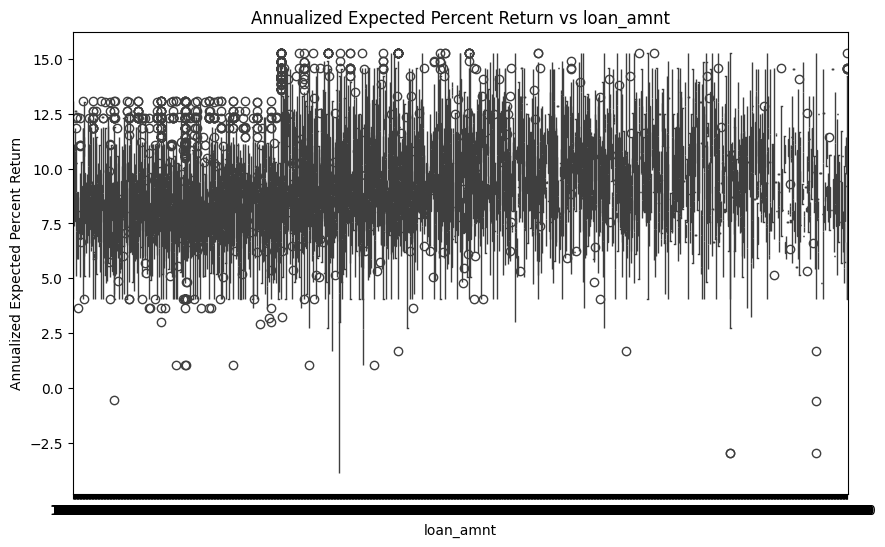

In [ ]:
# plot expected return vs. each of the top 5 features
top_5_features = importances_df['Feature'].head(5).tolist()

import matplotlib.pyplot as plt
import seaborn as sns
for feature in top_5_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='ann_exp_pct_ret', data=accepted_reduced)
    plt.title(f'Annualized Expected Percent Return vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Annualized Expected Percent Return')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


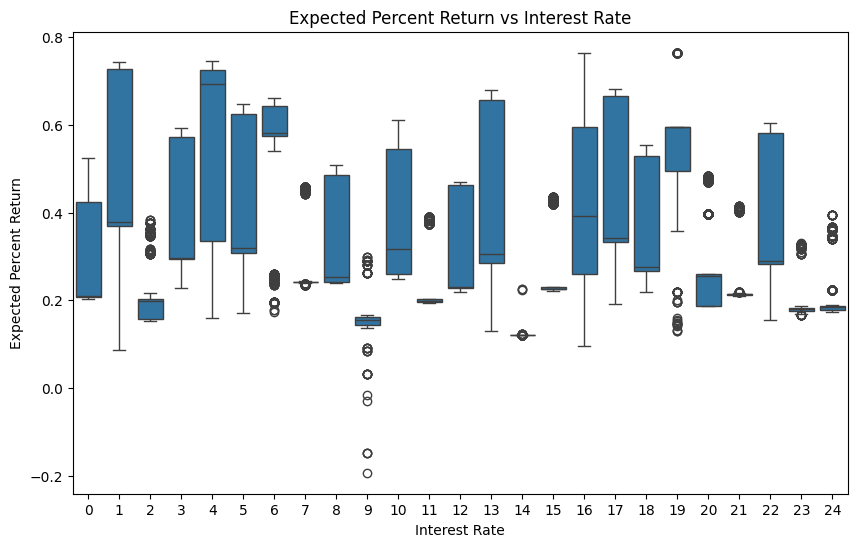

In [ ]:

# Create a copy of the DataFrame
df_copy = accepted_reduced.copy()

# Define the number of clusters
num_clusters = 25

# Use KMeans to cluster the interest rates
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_copy['int_rate'].values.reshape(-1, 1))

# Add the cluster labels to the DataFrame
df_copy['int_rate_cluster'] = kmeans.labels_

# Plot the expected percent return vs. interest rate
plt.figure(figsize=(10, 6))
sns.boxplot(x='int_rate_cluster', y='expected_percent_return', data=df_copy)
plt.title('Expected Percent Return vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Expected Percent Return')
plt.show()


In [ ]:
# determining exactly what grade and interest rate is needed
# calculate value for all loans
avg_ir = accepted_reduced["int_rate"].mean()
avg_subgrade = accepted_reduced["sub_grade_encoded"].mean()
avg_grade = accepted_reduced["grade_encoded"].mean()

print("All loans average values -->")
print("interest rate: ", avg_ir)
print("subgrade: ", avg_subgrade)
print("grade: ", avg_grade)

All loans average values -->
interest rate:  13.737114725188599
subgrade:  10.865582443421182
grade:  1.7740178309003625


Now we will de-encode the encoded loan grades to see if higher or lower grade loans result in higher expected returns.

In [ ]:
# determining what encoded sugrade and grade represent; code source: ChatGPT
import itertools

# 1. grade
# Create a DataFrame containing all unique combinations of values from columns 'grade' and 'grade_encoded'
unique_combinations_df = pd.DataFrame(list(itertools.product(accepted_reduced['grade'].unique(), accepted_reduced['grade_encoded'].unique())), columns=['grade', 'grade_encoded'])

# Filter out combinations that occur in the original DataFrame
unique_combinations_occurred = unique_combinations_df[
    unique_combinations_df.apply(lambda x: ((accepted_reduced['grade'] == x['grade']) & (accepted_reduced['grade_encoded'] == x['grade_encoded'])).any(), axis=1)
]

# Print out the unique combinations that occur in the original DataFrame
for index, row in unique_combinations_occurred.iterrows():
    print(row['grade'], row['grade_encoded'])
print("\n")

# 2. sub grade
# Create a DataFrame containing all unique combinations of values from columns 'sub_grade' and 'sub_grade_encoded'
unique_combinations_df = pd.DataFrame(list(itertools.product(accepted_reduced['sub_grade'].unique(), accepted_reduced['sub_grade_encoded'].unique())), columns=['sub_grade', 'sub_grade_encoded'])

# Filter out combinations that occur in the original DataFrame
unique_combinations_occurred = unique_combinations_df[
    unique_combinations_df.apply(lambda x: ((accepted_reduced['sub_grade'] == x['sub_grade']) & (accepted_reduced['sub_grade_encoded'] == x['sub_grade_encoded'])).any(), axis=1)
]

# Print out the unique combinations that occur in the original DataFrame
for index, row in unique_combinations_occurred.iterrows():
    print(row['sub_grade'], row['sub_grade_encoded'])

D 3
E 4
B 1
C 2
A 0
F 5
G 6


D3 17
E4 23
B4 8
D4 18
B3 7
C5 14
B1 5
C3 12
D2 16
C4 13
D1 15
B2 6
A5 4
E3 22
A3 2
F5 29
C2 11
C1 10
B5 9
D5 19
A1 0
F2 26
F4 28
G2 31
A2 1
A4 3
E2 21
F1 25
E1 20
E5 24
G5 34
F3 27
G1 30
G3 32
G4 33


Result: lower grade (riskier) loans result in higher returns -- grade E or below, subgrade D4 or below

In [ ]:
#Expected Value calculations
grade_default_rates = accepted_reduced.groupby('grade')['loan_status_bin'].mean()
term_avg = accepted_reduced.groupby('grade')['term'].mean()
grade_default_probabilities = 1 - grade_default_rates
print("Probability of Default by Loan Grade:")
print(grade_default_probabilities)

grade_int_rate = accepted_reduced.groupby('grade')['int_rate'].mean()
print("Interest Rate by grade:")
print(grade_int_rate)
'''
expected_value =  ((grade_default_probabilities) * -2000 +(1-grade_default_probabilities) * 2000 * (1+(grade_int_rate/1200)) ** (term_avg)).round()
print("Expected Value by Grade: ")
print(expected_value)
'''

Probability of Default by Loan Grade:
grade
A    0.032657
B    0.076104
C    0.126377
D    0.166750
E    0.253280
F    0.344956
G    0.379661
Name: loan_status_bin, dtype: float64
Interest Rate by grade:
grade
A     7.176309
B    10.558928
C    14.204845
D    18.842782
E    23.781195
F    27.565816
G    29.933492
Name: int_rate, dtype: float64


'\nexpected_value =  ((grade_default_probabilities) * -2000 +(1-grade_default_probabilities) * 2000 * (1+(grade_int_rate/1200)) ** (term_avg)).round()\nprint("Expected Value by Grade: ")\nprint(expected_value)\n'

In [ ]:
defaulted = (grade_default_probabilities*-2000)
int_rates = (grade_int_rate/100)

expected_return = defaulted+(1-grade_default_probabilities)*2000*(1+(int_rates/12)*term_avg)
print("Expected Return on Interest By Grade:")
print(((expected_return-2000) / 2000) * 100)


Expected Return on Interest By Grade:
grade
A    14.855206
B    16.479831
C    20.079442
D    26.606853
E    22.614763
F    13.827191
G    10.617809
dtype: float64


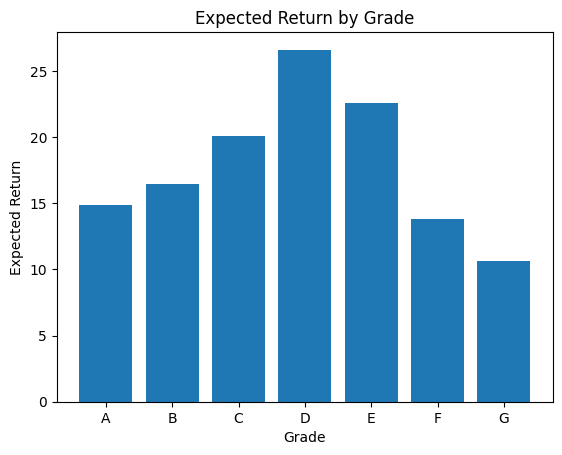

In [ ]:
import matplotlib.pyplot as plt

# Create some data
term_avg = [14.855206, 16.479831, 20.079442, 26.606853, 22.614763, 13.827191, 10.617809]
grade = ["A", "B", "C", "D", "E", "F", "G"]

# Create the bar chart
plt.bar(grade, term_avg)
plt.xlabel("Grade")
plt.ylabel("Expected Return")
plt.title("Expected Return by Grade")
plt.show()



**Recommendation:** To ensure maximum return on his investments, Dr. D should invest in low-grade loans (E, F, G) between 10,000 and 35,000 dollars with high interest rates to be paid off over 5 years.

## Dr. D will have enough investment opportunities to use this strategy

In [ ]:
#Dataframe analysis
hrt_df = high_return_df.copy()
print(len(hrt_df))
print((hrt_df.head()))

In [ ]:
'''term -- 60 months rather than 30 months
int_rate -- high, between 16 and 30%
sub_grade_encoded -- high, subgrade 23 or above
grade_encoded -- high, grade 4 or above
loan amount -- between 10,000 and 30,000'''

print("Number of loans that meet this criteria")
# Criteria met is a variable of the total number of requirements for our strategy

hrt_df = high_return_df.copy()

#print(len(hrt_df))
hrt_df.loc['criteria_met'] = (
    (hrt_df['term'] == 60).astype(bool) &
    (hrt_df["int_rate"] >= high_avg_subgrade).astype(bool)

)
# if we multiply the total number of loans by the average amount, we will see that Dr.D will have plently of loans to invest in
print(len(hrt_df.loc['criteria_met']))
print("Number of loans * average loan amount:")
print(62*20000)